## Import the necessary libraries

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from wordcloud import WordCloud
#from helper_prabowo_ml import clean_html, remove_links, remove_special_characters, removeStopWords, remove_, remove_digits, lower, email_address, non_ascii, punct, hashtags
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

/home/bauti/Documents/Facultad/4°/ia2-language-detection/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Updating the default configuration

In [4]:
plt.rcParams['figure.figsize'] = (12,8)

## Loading the dataset

In [7]:
df = pd.read_csv("dataset/updated_language_detection.csv")
df = df.sample(frac=1)
df.head()

,Text,Language
9105,le domaine entre dans la famille parseval à ...,French
13426,en roissy était un village du pays de france ...,French
7653,il est nommé le janvier conservateur du nouv...,French
10521,această vestă este mai largă având o formă tri...,Romanian
15947,vestiges du château des caramans parc de la ma...,French


## Encoding the target label classes

In [8]:
labels_dict = {}
for idx, lang in enumerate(df.Language.unique()):
    labels_dict[lang] = idx
labels_dict

{'French': 0,
 'Romanian': 1,
 'Estonian': 2,
 'Turkish': 3,
 'Russian': 4,
 'English': 5,
 'Portugese': 6,
 'Chinese': 7,
 'Japanese': 8,
 'Indonesian': 9,
 'Pushto': 10,
 'Tamil': 11,
 'Urdu': 12,
 'Latin': 13,
 'Spanish': 14,
 'Thai': 15,
 'Korean': 16,
 'Persian': 17,
 'Dutch': 18,
 'Hindi': 19,
 'Arabic': 20,
 'Swedish': 21}

In [9]:
df['Label'] = df.Language.map(labels_dict)
df.head()

,Text,Language,Label
9105,le domaine entre dans la famille parseval à ...,French,0
13426,en roissy était un village du pays de france ...,French,0
7653,il est nommé le janvier conservateur du nouv...,French,0
10521,această vestă este mai largă având o formă tri...,Romanian,1
15947,vestiges du château des caramans parc de la ma...,French,0


In [10]:
df.sample(frac=1)

,Text,Language,Label
17766,ianuarie cei doi teroriști implicați în atent...,Romanian,1
5091,بَیْت‌المُقدَّس به عربی بَيْتُ الْمَقْدِس یا ا...,Persian,17
20791,年月日から「アクアンナイト」と称したナイター競走を実施。初めてナイター競走を開催した競艇場で...,Japanese,8
14155,vǎlko červenkov oli abielus elna dimitrovaga k...,Estonian,2
3848,les finales de et sont arbitrées par allan h...,French,0
...,...,...,...
17035,avec ce nouveau journal il se montre particuli...,French,0
1431,இசுலாமிய காலக்கட்டத்துக்கு முந்தைய காலக் கட்டம...,Tamil,11
2704,uusbütsantsi stiili kasutati enamasti sakraals...,Estonian,2
15097,خلیج جوشان رویه‌ای صاف و کم‌وبیش بدون عارضه دا...,Persian,17


## Splitting the preprocessed dataset into train and test sets

In [11]:
train_df, test_df = train_test_split(df,test_size=0.3,random_state=42,shuffle=True,stratify=df.Language)

## Downloading the pretrained tokenizer and xlm-roberta-base language detection model

In [12]:
tokenizer = AutoTokenizer.from_pretrained("papluca/xlm-roberta-base-language-detection")
xlm = TFAutoModelForSequenceClassification.from_pretrained("papluca/xlm-roberta-base-language-detection",from_pt=True)

2024-12-10 19:51:36.839054: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2024-12-10 19:51:51.700323: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 768006144 exceeds 10% of free system memory.
2024-12-10 19:51:55.021389: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 768006144 exceeds 10% of free system memory.
2024-12-10 19:51:55.907133: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 768006144 exceeds 10% of free system memory.
2024-12-10 19:52:07.297161: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 768006144 exceeds 10% of free system memory.
2024-12-10 19:52:08.293103: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 768006144 exceeds 10% of free system memory.
Some weights of the PyTorch model were not used when initi

## Performing text tokenization

In [13]:
max_len = 200
X_train = tokenizer(text=train_df.Text.tolist(),
                   max_length=max_len,
                   padding=True,
                   truncation=True,
                   add_special_tokens=True,
                   return_tensors="tf",
                   return_attention_mask=True,
                   return_token_type_ids=False,
                   verbose=True)

X_test = tokenizer(text=test_df.Text.tolist(),
                  max_length=max_len,
                  padding=True,
                  truncation=True,
                  add_special_tokens=True,
                  return_tensors="tf",
                  return_attention_mask=True,
                  return_token_type_ids=False,
                  verbose=True)

## Fine-tuning the pretrained xlm-roberta-base language detection model

In [14]:
input_ids = Input(shape=(max_len,),dtype=tf.int32,name='input_ids')
attention_mask = Input(shape=(max_len,),dtype=tf.int32,name='attention_mask')

In [15]:
embeddings = xlm(input_ids,attention_mask=attention_mask)[0] # 0 --> final hidden state, 1 --> pooling output
output = Flatten()(embeddings)
output = Dense(units=1024,activation='relu')(output)
output = Dropout(0.3)(output)
output = Dense(units=512,activation='relu')(output)
output = Dropout(0.2)(output)
output = Dense(units=512,activation='relu')(output)
output = Dropout(0.2)(output)
output = Dense(units=128,activation='relu')(output)
output = Dense(units=10,activation='softmax')(output)

model = Model(inputs=[input_ids,attention_mask],outputs=output)
model.layers[2].trainable = True

ValueError: Exception encountered when calling layer 'tfxlm_roberta_for_sequence_classification' (type TFXLMRobertaForSequenceClassification).

Data of type <class 'keras.src.backend.common.keras_tensor.KerasTensor'> is not allowed only (<class 'tensorflow.python.framework.tensor.Tensor'>, <class 'bool'>, <class 'int'>, <class 'transformers.utils.generic.ModelOutput'>, <class 'tuple'>, <class 'list'>, <class 'dict'>, <class 'numpy.ndarray'>) is accepted for attention_mask.

Call arguments received by layer 'tfxlm_roberta_for_sequence_classification' (type TFXLMRobertaForSequenceClassification):
  • input_ids=<KerasTensor shape=(None, 200), dtype=int32, sparse=False, name=input_ids>
  • attention_mask=<KerasTensor shape=(None, 200), dtype=int32, sparse=False, name=attention_mask>
  • token_type_ids=None
  • position_ids=None
  • head_mask=None
  • inputs_embeds=None
  • output_attentions=None
  • output_hidden_states=None
  • return_dict=None
  • labels=None
  • training=False

## Model Architecture

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 125)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 125)]        0                                            
__________________________________________________________________________________________________
tfxlm_roberta_for_sequence_clas TFSequenceClassifier 278059028   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
flatten (Flatten)               (None, 20)           0           tfxlm_roberta_for_sequence_cl

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


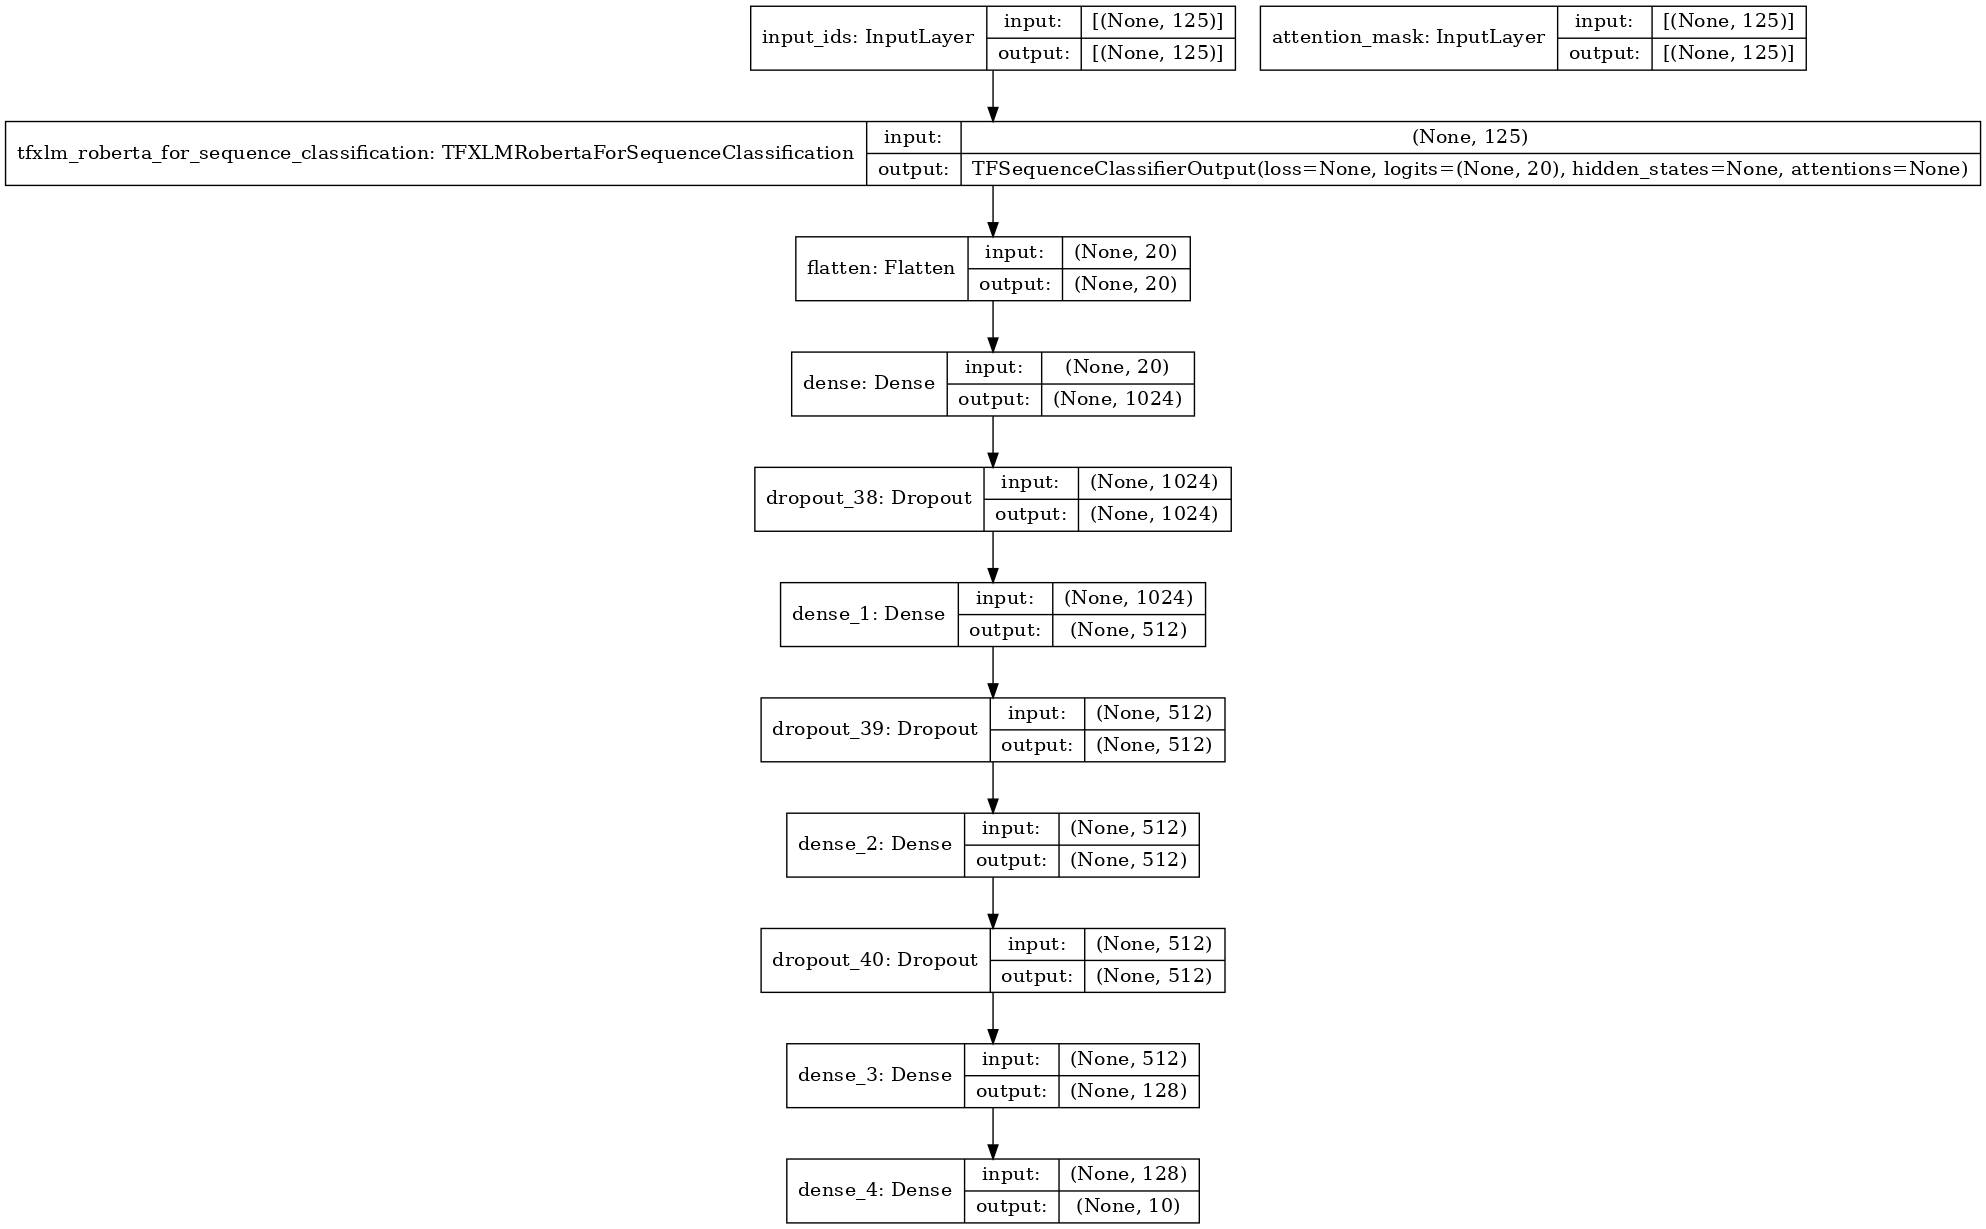

In [27]:
plot_model(model,'model.png',show_shapes=True,dpi=100,rankdir='TB')

## Compiling the model

In [28]:
optimizer = Adam(learning_rate=5e-5,epsilon=2e-8,decay=0.01,clipnorm=1.0)
loss = CategoricalCrossentropy()
metrics = CategoricalAccuracy('balanced_accuracy')
model.compile(loss=loss,optimizer=optimizer,metrics=metrics)

## Training the fine-tuned XLM-Roberta-Base transformer model

In [29]:
es = EarlyStopping(monitor='val_balanced_accuracy',patience=20,verbose=1,mode='max',restore_best_weights=True)
mc = ModelCheckpoint(filepath='checkpoint',monitor='val_balanced_accuracy',mode='max',save_best_only=True,verbose=1)

r = model.fit(x={'input_ids': X_train['input_ids'], 'attention_mask': X_train['attention_mask']},
              y=to_categorical(train_df.Label),
              epochs=50,
              batch_size=64,
              callbacks=[es,mc],
              validation_data=({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},to_categorical(test_df.Label))
             )

2022-12-21 09:34:52.611420: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
80/80 [==============================] - 163s 2s/step - loss: 1.3802 - balanced_accuracy: 0.6730 - val_loss: 0.5346 - val_balanced_accuracy: 0.8759


2022-12-21 09:37:36.178344: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 768006144 exceeds 10% of free system memory.
2022-12-21 09:37:37.490590: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 768006144 exceeds 10% of free system memory.



Epoch 00001: val_balanced_accuracy improved from -inf to 0.87586, saving model to checkpoint


2022-12-21 09:37:52.311671: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-12-21 09:38:28.250443: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 768006144 exceeds 10% of free system memory.
2022-12-21 09:38:29.315618: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 768006144 exceeds 10% of free system memory.
2022-12-21 09:38:30.410041: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 768006144 exceeds 10% of free system memory.


Epoch 2/50
80/80 [==============================] - 143s 2s/step - loss: 0.4218 - balanced_accuracy: 0.9013 - val_loss: 0.1863 - val_balanced_accuracy: 0.9752

Epoch 00002: val_balanced_accuracy improved from 0.87586 to 0.97517, saving model to checkpoint
Epoch 3/50
80/80 [==============================] - 143s 2s/step - loss: 0.1536 - balanced_accuracy: 0.9765 - val_loss: 0.1177 - val_balanced_accuracy: 0.9770

Epoch 00003: val_balanced_accuracy improved from 0.97517 to 0.97701, saving model to checkpoint
Epoch 4/50
80/80 [==============================] - 143s 2s/step - loss: 0.0825 - balanced_accuracy: 0.9858 - val_loss: 0.1207 - val_balanced_accuracy: 0.9761

Epoch 00004: val_balanced_accuracy did not improve from 0.97701
Epoch 5/50
80/80 [==============================] - 143s 2s/step - loss: 0.0728 - balanced_accuracy: 0.9858 - val_loss: 0.1210 - val_balanced_accuracy: 0.9775

Epoch 00005: val_balanced_accuracy improved from 0.97701 to 0.97747, saving model to checkpoint
Epoch 6/

## Analyzing the overall performance of trained model

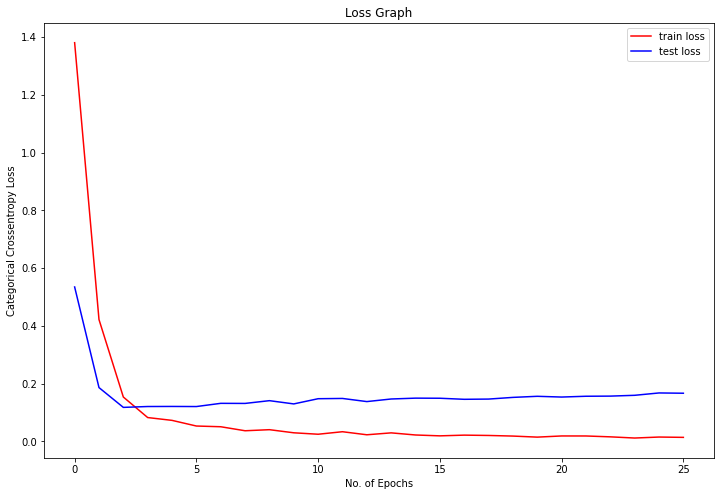

In [30]:
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='test loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Categorical Crossentropy Loss')
plt.title('Loss Graph')
plt.legend();

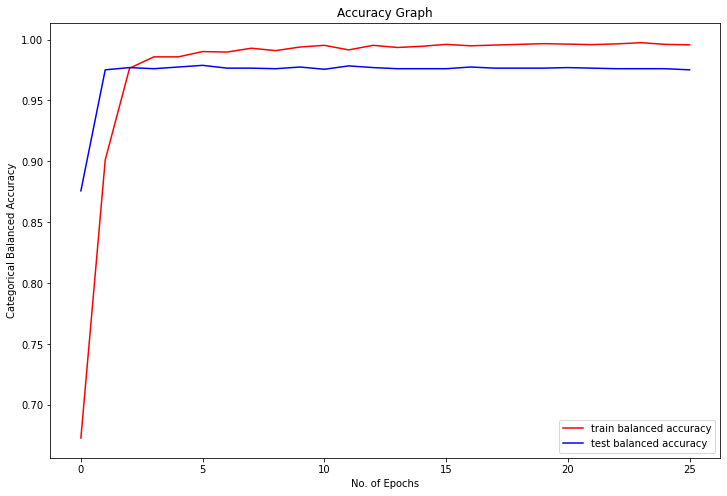

In [31]:
plt.plot(r.history['balanced_accuracy'],'r',label='train balanced accuracy')
plt.plot(r.history['val_balanced_accuracy'],'b',label='test balanced accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Categorical Balanced Accuracy')
plt.title('Accuracy Graph')
plt.legend();

## Saving the model

In [32]:
model.save('language_detector.h5')

## Model Evaluation

In [33]:
loss, acc = model.evaluate({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},to_categorical(test_df.Label))
print("Categorical Cross-entropy Loss:", loss)
print("Categorical Accuracy:", acc)

68/68 [==============================] - 18s 261ms/step - loss: 0.1206 - balanced_accuracy: 0.9789
Categorical Cross-entropy Loss: 0.12063389271497726
Categorical Accuracy: 0.9788506031036377


In [37]:
test_predictions = model.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']})
test_predictions = np.argmax(test_predictions,axis=1)
print("Confusion Matrix:")
print(confusion_matrix(test_df.Label,test_predictions))
print('-----------------------------')
print("Encoded Labels:")
print(labels_dict)
print('-----------------------------')
print("Classification Report:")
print(classification_report(test_df.Label,test_predictions))

Confusion Matrix:
[[205   2   0   0   0   0   2   0   0   0]
 [  0 220   0   2   0   0   0   0   0   0]
 [  0   0 140   0   1   0   0   1   0   0]
 [  2   0   0 412   1   0   1   0   0   0]
 [  0   0   1   0 137   0   0   0   1   2]
 [  0   0   0   1   0 201   0   0   0   1]
 [  1   6   0   0   0   0 237   0   2   0]
 [  0   0   1   2   1   0   1 158   0   1]
 [  2   1   1   0   0   0   2   0 297   1]
 [  0   0   0   0   0   5   0   0   1 122]]
-----------------------------
Encoded Labels:
{'Italian': 0, 'Portuguese': 1, 'Turkish': 2, 'English': 3, 'German': 4, 'Swedish': 5, 'Spanish': 6, 'Dutch': 7, 'French': 8, 'Danish': 9}
-----------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       209
           1       0.96      0.99      0.98       222
           2       0.98      0.99      0.98       142
           3       0.99      0.99      0.99       416
           4       0.98      0.97      0.9

The results are quite outstanding as the fine-tuned xlm-roberta-base transformer model has produced an amazing f1-score of more than 95% for all the languages.

If you adore my work, please don't forget to upvote it! 